# EDA MentalRiskES - 2025

In [1]:
import sys
import os

# Obtener la ruta absoluta del directorio base usando rutas relativas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))

# Agregar `src` a sys.path para que los imports funcionen
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

print(BASE_DIR)

C:\Users\jeiso\Documents\Maestria\Semestre #1\NLP\IberLEF2025\MentalRiskES\src


In [2]:
import re
import json
import nltk
import emoji
import string
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from data_aug import DataAugmenter
from text_preprocessing  import DatasetColumnTransformer
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeiso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jeiso\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Get the root directory of the project (assuming the notebook is inside "notebook/")
notebook_dir = os.getcwd()  # Gets the current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Moves one level up
project_root

'C:\\Users\\jeiso\\Documents\\Maestria\\Semestre #1\\NLP\\IberLEF2025\\MentalRiskES'

## Load messages and user tags to create a dataset

In [4]:
# Define paths relative to the project root
json_dir = os.path.join(project_root, "data", "train", "task2", "subjects")
user_categories_file = os.path.join(project_root, "data", "train", "task2", "gold_task2.txt")
gambling_level_file = os.path.join(project_root, "data", "train", "task1", "gold_task1.txt")

# Load messages from JSON files
data = []
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        user = filename.replace('.json', '')  # Extract user ID from filename
        with open(os.path.join(json_dir, filename), "r", encoding="utf-8") as f:
            messages = json.load(f)
            if isinstance(messages, list):
                # Add each message to the list, keeping the "User" field
                data.extend({**entry, "User": user} for entry in messages if isinstance(entry, dict))
            else:
                print(f"Warning: {filename} does not contain a list of messages.")

# Create DataFrame if data exists
df = pd.DataFrame(data)
if not df.empty:
    df = df[['User', 'date', 'message', 'platform']]  # Reorder columns

# Function to load and merge category data
def merge_category(df, file_path, col_name):
    """Loads a CSV file and merges it with the DataFrame based on 'User' column."""
    category_df = pd.read_csv(file_path, dtype={"Subject": str})
    return df.merge(category_df.rename(columns={'Subject': 'User', col_name: col_name.lower()}), on='User', how='left')

# Merge user categories (Type) and gambling risk levels (Risk)
df = merge_category(df, user_categories_file, 'Type')
df = merge_category(df, gambling_level_file, 'Risk')

# Display the first few rows of the final DataFrame
df.head()

,User,date,message,platform,type,risk
0,user10040,2021-04-27 22:30:20+01:00,El canal del amigo se llama loco por el trading ?,Telegram,trading,0
1,user10040,2021-04-28 00:12:59+01:00,Hay vivo hoy ?,Telegram,trading,0
2,user10040,2021-04-29 01:11:42+01:00,Eos alguien lo vio ?,Telegram,trading,0
3,user10040,2021-04-29 02:15:10+01:00,A que hora es el vivo ?,Telegram,trading,0
4,user10040,2021-04-30 03:13:18+01:00,No arranca vet,Telegram,trading,0


## Distribution of words per message

Estadísticas de la distribución de la longitud de los mensajes:
count    22491.000000
mean         8.343026
std         10.215357
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max        467.000000
Name: message_length, dtype: float64


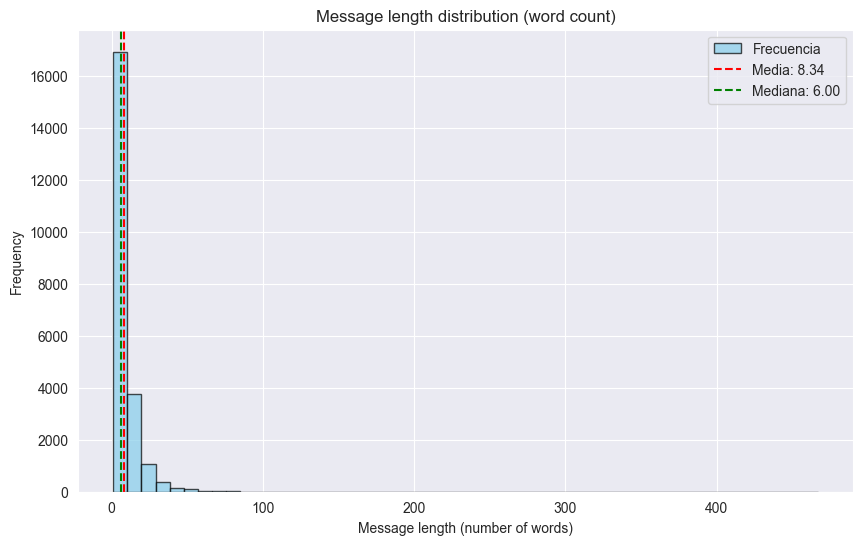

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure all values are strings and handle NaN
df['message'] = df['message'].astype(str).fillna('')

# Calculate the length of each message (in number of words)
df['message_length'] = df['message'].apply(lambda x: len(x.split()))

# Display descriptive statistics of message lengths
print("Estadísticas de la distribución de la longitud de los mensajes:")
print(df['message_length'].describe())

# Calculate the mean and median to annotate them on the plot
mean_value = df['message_length'].mean()
median_value = df['message_length'].median()

# Create a histogram to visualize the distribution of message lengths
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(df['message_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label="Frecuencia")

# Add title and axis labels
plt.title('Message length distribution (word count)')
plt.xlabel('Message length (number of words)')
plt.ylabel('Frequency')
plt.grid(True)

# Draw vertical lines for the mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5, label=f'Mediana: {median_value:.2f}')

# Add legend to the histogram
plt.legend()

# Display the plot
plt.show()

## Distribution of words per gambling category

Average number of words per category:
risk
0    8.563161
1    8.115183
Name: message_length, dtype: float64


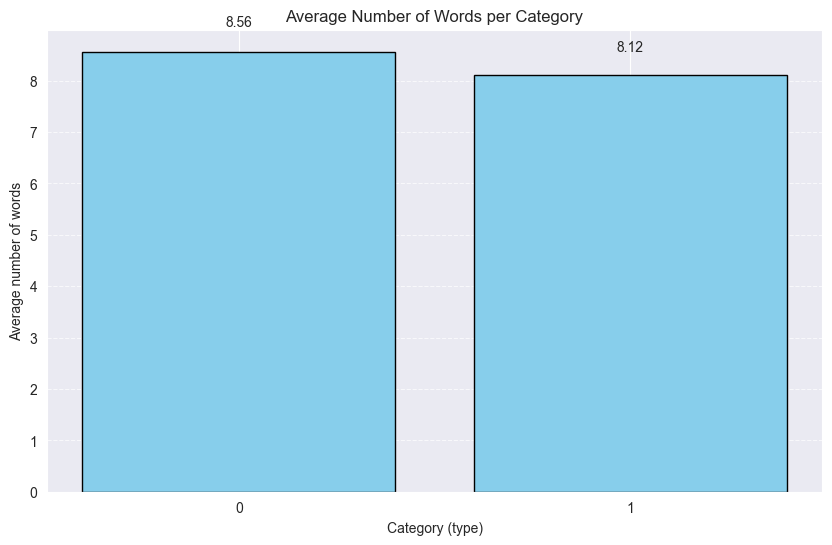

In [6]:
# Ensure all values are strings and handle NaN
df['message'] = df['message'].astype(str).fillna('')

# Calculate the length of each message in number of words
df['message_length'] = df['message'].apply(lambda x: len(x.split()))

# Calculate the average number of words per category in the "type" column
category_mean = df.groupby('risk')['message_length'].mean()

# Print the average word count for each category
print("Average number of words per category:")
print(category_mean)

# Plot the average word count using a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(category_mean.index.astype(str), category_mean.values, color='skyblue', edgecolor='black')
plt.xlabel('Category (type)')
plt.ylabel('Average number of words')
plt.title('Average Number of Words per Category')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the numerical value above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05 * yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

## Platform distribution

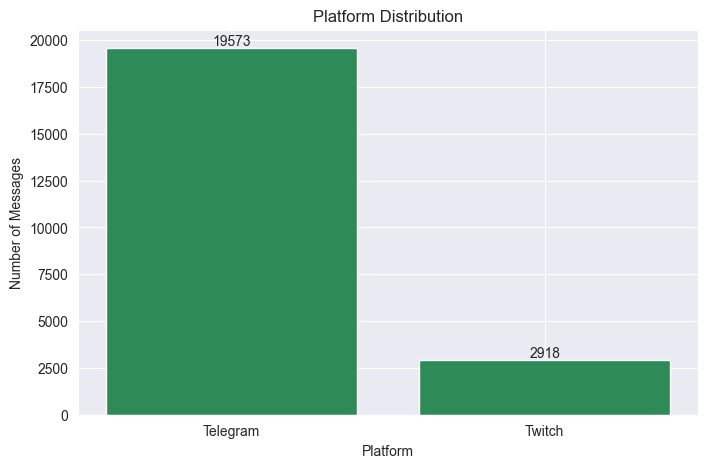

In [7]:
platform_counts = df['platform'].value_counts()

plt.figure(figsize=(8,5))
bars = plt.bar(platform_counts.index, platform_counts.values, color='seagreen')
plt.title("Platform Distribution")
plt.xlabel("Platform")
plt.ylabel("Number of Messages")

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.show()

## Most Frequent Words in Messages

C:\Users\jeiso\AppData\Local\Temp\ipykernel_20664\2429451479.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='Count', data=word_df, palette="viridis")


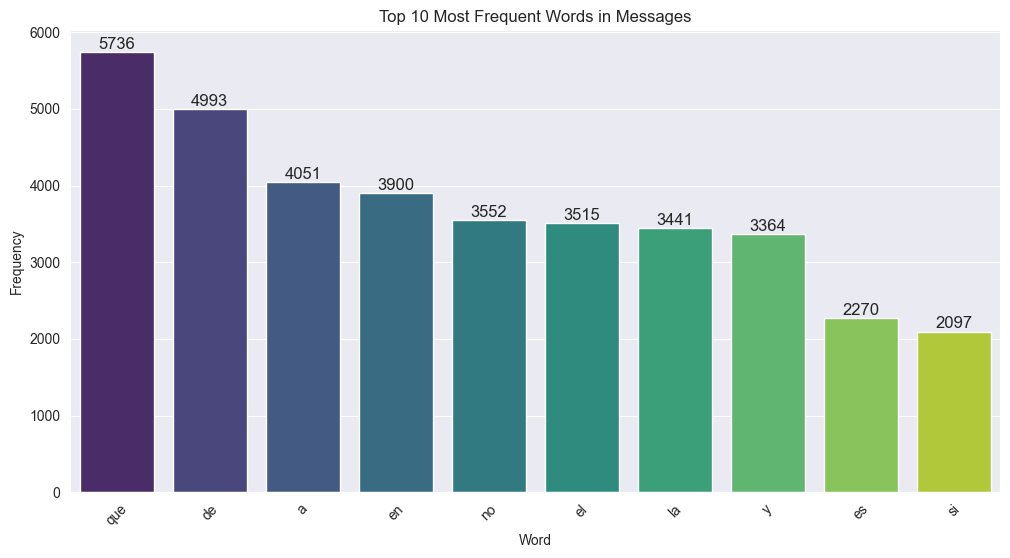

In [8]:
# Function to preprocess text (remove punctuation and lowercase)
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()  # Convert to lowercase

# Apply preprocessing and split words
words = ' '.join(df['message'].dropna().apply(preprocess_text)).split()

# Count word frequencies
word_counts = Counter(words)

# Get the 10 most common words
most_common_words = word_counts.most_common(10)

# Convert to DataFrame for plotting
word_df = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Word', y='Count', data=word_df, palette="viridis")

# Add text labels above each bar
for i, v in enumerate(word_df['Count']):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=12)

plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Words in Messages")
plt.xticks(rotation=45)  # Rotate words for better readability
plt.show()

## Most Frequent Words in Messages (Without Stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeiso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


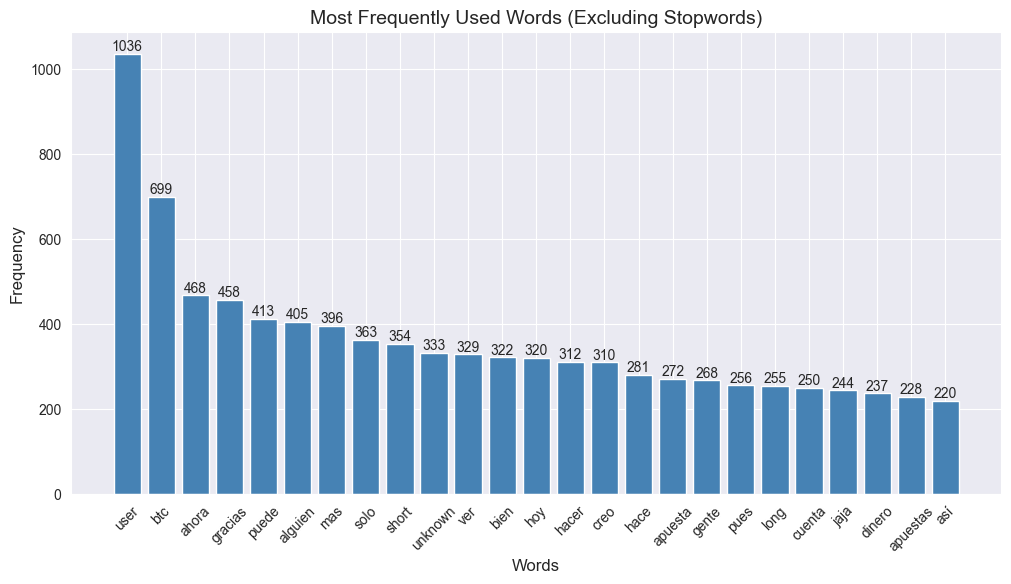

In [9]:
# Download stopwords if you have not already done so
nltk.download('stopwords')

# List of stopwords in Spanish
stop_words = set(stopwords.words('spanish'))

# Function for clearing and tokenizing messages
def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words

# Apply cleanup to all rows and word count
all_words = df['message'].dropna().apply(clean_text).explode()
word_counts = Counter(all_words)

# Obtain the 15 most frequent words
top_words = word_counts.most_common(25)

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar([word[0] for word in top_words], [word[1] for word in top_words], color='steelblue')
plt.title("Most Frequently Used Words (Excluding Stopwords)", fontsize=14)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45)
plt.show()

## Message Distribution per User

In [10]:
# Assuming df is your DataFrame and 'user' is the column with usernames
message_counts = df['User'].value_counts()

# Print the message count per user
print(message_counts)

User
user3387     146
user179      145
user3926     142
user301      142
user3488     134
            ... 
user28719      8
user28487      8
user28486      8
user28726      8
user28585      8
Name: count, Length: 350, dtype: int64


## Emoji Frequency Count

In [11]:
# Function to extract emojis from text
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Apply the extraction function to each message
df['emojis'] = df['message'].apply(extract_emojis)

# Count the occurrences of each emoji
emoji_list = [e for sublist in df['emojis'] for e in sublist]
emoji_counts = Counter(emoji_list)

# Print the emoji frequency count in a single line
emoji_output = ", ".join(f"{emoji_char}: {count}" for emoji_char, count in emoji_counts.items())
print(emoji_output)

🤨: 8, 😰: 6, 🤣: 194, 🐻: 1, 👁: 2, 😂: 845, 😔: 22, 🈚: 1, ❤: 4, ☺: 6, 😁: 55, 💵: 1, 🤑: 31, 🙄: 24, 🤪: 8, 😕: 3, 👍: 143, 😅: 102, 👏: 109, 😍: 17, 🙈: 19, 😊: 26, 😎: 27, 🤷: 34, 🏻: 152, ♂: 91, 🚀: 60, 😳: 40, 😡: 11, 😭: 45, 😪: 6, 🐳: 3, 💪: 53, 😬: 19, 💦: 4, 💔: 2, 💲: 3, 😆: 35, 😜: 25, 👌: 50, 😀: 6, 🤭: 8, 😚: 1, 😢: 23, 🥲: 16, 🤦: 60, ✊: 3, 🏼: 45, ☀: 1, 😌: 6, ⬇: 3, 🥰: 6, 🤔: 30, 😒: 7, ✅: 30, 😉: 16, 😐: 6, 😮: 5, 🚨: 28, 😝: 6, 👋: 7, ❗: 5, 💥: 7, 🔹: 2, ✨: 4, 🔰: 1, 💬: 2, 🐬: 1, 🌕: 1, 😱: 32, 🙏: 23, 🏽: 35, 🔮: 5, ⛔: 2, 🔥: 20, 👀: 26, 💰: 1, 🤓: 4, ♀: 8, 🫣: 3, 🫤: 1, 🤘: 3, 🦥: 1, 👆: 5, 🚫: 2, ☹: 1, 🧐: 24, 🥵: 3, 🥶: 5, 🎼: 3, 🤡: 2, 😃: 5, 🤙: 8, 🙆: 1, 😄: 16, 🌖: 3, ✌: 10, ♥: 9, 🙌: 19, 🥴: 6, 🥹: 3, 🫡: 2, 😏: 7, 😹: 11, 🪂: 2, 🌙: 1, 🎄: 2, 😛: 2, 🤞: 16, 💫: 3, 🌝: 3, 🌊: 4, 🥚: 4, 🎶: 1, 🎵: 1, 🍎: 9, 🍏: 21, 🤠: 1, 🥳: 7, 😴: 1, ✈: 1, 🤯: 5, 😶: 5, 🌫: 2, 🙃: 2, 😥: 5, 😠: 3, 🟢: 5, 😇: 2, 💩: 1, 💃: 1, 🕺: 1, 🍻: 1, 😞: 5, 🤩: 1, 🥸: 1, 🙂: 2, 🥱: 1, 💶: 5, 🐷: 3, 🥒: 4, 🗣: 2, ⚓: 1, 🐟: 1, 👉: 3, 👈: 2, 👎: 1, 🎁: 3, 💎: 1, 🎅: 1, 🐁: 3, 🐗: 1, 🍺: 1, 🍀: 2, 🤤: 4, 🔝: 3, 😓: 4, 😘: 16, 

## Message Counting with HTML, Markdown, URLS, Emails and Mentions

In [12]:
# Regular expressions for different patterns
html_pattern = re.compile(r'(<[^>]+>)')  # HTML tags
markdown_pattern = re.compile(r'(\[.*?\]\(.*?\)|\*\*.*?\*\*|__.*?__|`.*?`|#+\s)')  # Markdown syntax
email_pattern = re.compile(r'([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})')  # Email addresses
mention_pattern = re.compile(r'(@\w+)')  # Mentions (e.g., @user)
url_pattern = re.compile(r'(https?://\S+|www\.\S+)')  # URLs

# Function to extract matches
def extract_matches(pattern, text):
    matches = pattern.findall(text)
    return matches if matches else None

# Apply functions to extract matches
df['html_matches'] = df['message'].apply(lambda x: extract_matches(html_pattern, x))
df['markdown_matches'] = df['message'].apply(lambda x: extract_matches(markdown_pattern, x))
df['email_matches'] = df['message'].apply(lambda x: extract_matches(email_pattern, x))
df['mention_matches'] = df['message'].apply(lambda x: extract_matches(mention_pattern, x))
df['url_matches'] = df['message'].apply(lambda x: extract_matches(url_pattern, x))

# Count occurrences
html_count = df['html_matches'].dropna().count()
markdown_count = df['markdown_matches'].dropna().count()
email_count = df['email_matches'].dropna().count()
mention_count = df['mention_matches'].dropna().count()
url_count = df['url_matches'].dropna().count()

# Print results
print(f"Messages containing HTML: {html_count}")
print(f"Messages containing Markdown: {markdown_count}")
print(f"Messages containing Emails: {email_count}")
print(f"Messages containing Mentions: {mention_count}")
print(f"Messages containing URLs: {url_count}")

# Print up to 5 examples for each case
print("\nHTML fragments:")
print(", ".join([match for sublist in df['html_matches'].dropna().head(5) for match in sublist]))

print("\nMarkdown fragments:")
print(", ".join([match for sublist in df['markdown_matches'].dropna().head(5) for match in sublist]))

print("\nEmails:")
print(", ".join([match for sublist in df['email_matches'].dropna().head(5) for match in sublist]))

print("\nMentions:")
print(", ".join([match for sublist in df['mention_matches'].dropna().head(5) for match in sublist]))

print("\nURLs:")
print(", ".join([match for sublist in df['url_matches'].dropna().head(5) for match in sublist]))

Messages containing HTML: 0
Messages containing Markdown: 0
Messages containing Emails: 1
Messages containing Mentions: 318
Messages containing URLs: 0

HTML fragments:


Markdown fragments:


Emails:
estoesuntimo@USER.com

Mentions:
@USER, @USER, @USER, @USER, @USER

URLs:



## Concatenate user messages using the separate [SEP].

## Preprocessing Dataset

In [13]:
# Ensure 'df' contains only the necessary columns
df = df[['User', 'date', 'message', 'platform']].copy()
df['date'] = pd.to_datetime(df['date'])  # Convert date column to datetime format
df = df.sort_values('date')  # Sort messages chronologically

# Define separator for concatenating messages
separator = " [SEP] "

# Group messages by user, concatenating them with the defined separator
aggregated_df = df.groupby('User', as_index=False).agg({'message': separator.join})

# Load user labels and gambling risk level
label_files = {
    "label": r"C:\Users\jeiso\Documents\Maestria\Semestre #1\Reto\MentalRiskES-2025\data\train\task2\gold_task2.txt",
    "level": r"C:\Users\jeiso\Documents\Maestria\Semestre #1\Reto\MentalRiskES-2025\data\train\task1\gold_task1.txt",
}

for col, file in label_files.items():
    # Load only relevant columns to optimize performance
    user_data = pd.read_csv(file, usecols=["Subject", "Type" if col == "label" else "Risk"])
    user_data.rename(columns={"Subject": "User", "Type": "label", "Risk": "level"}, inplace=True)

    # Merge user labels with aggregated messages
    aggregated_df = aggregated_df.merge(user_data, on="User", how="left")

# Convert categorical columns to optimize memory usage
aggregated_df[['label', 'level']] = aggregated_df[['label', 'level']].astype("category")

# Display the final DataFrame
aggregated_df

,User,message,label,level
0,user10040,El canal del amigo se llama loco por el tradin...,trading,0
1,user10048,Ganancia es ganancia chicos [SEP] Si lo conseg...,trading,0
2,user10290,fijate cuanto es el margen en negativo y le ag...,trading,1
3,user10317,Alguna entradita .. ? [SEP] Spot está funciona...,trading,0
4,user10343,Voy cargando la escopeta pa longuear alguna mo...,trading,1
...,...,...,...,...
345,user9772,"Buenas , saben dónde se podrán ver las órdenes...",trading,0
346,user9774,Eso es bueno o malo ? [SEP] Tarde ? Hasta dond...,trading,0
347,user9873,que hora es el stream de user 12434 [SEP] Grac...,trading,0
348,user9893,"Hola gente , les hago una consulta : tengo uno...",trading,0


In [14]:
aggregated_df.to_excel('dataset_task1.xlsx', index=False)

In [15]:
preprocessor = DatasetColumnTransformer()
df = preprocessor.transform_column(df, 'message')
df

,User,date,message,platform,type,risk,message_length,emojis,html_matches,markdown_matches,email_matches,mention_matches,url_matches
0,user10040,2021-04-27 22:30:20+01:00,el canal del amigo se llama loco por el trading ?,Telegram,trading,0,11,[],None,None,None,None,None
1,user10040,2021-04-28 00:12:59+01:00,hay vivo hoy ?,Telegram,trading,0,4,[],None,None,None,None,None
2,user10040,2021-04-29 01:11:42+01:00,eos alguien lo vio ?,Telegram,trading,0,5,[],None,None,None,None,None
3,user10040,2021-04-29 02:15:10+01:00,a que hora e el vivo ?,Telegram,trading,0,7,[],None,None,None,None,None
4,user10040,2021-04-30 03:13:18+01:00,no arranca vet,Telegram,trading,0,3,[],None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22486,user9984,2022-10-08 01:33:29+01:00,"buenas , hoy hay directo ?",Telegram,trading,0,6,[],None,None,None,None,None
22487,user9984,2022-10-08 01:52:36+01:00,cara_sonriendo_con_cuernos,Telegram,trading,0,1,[😈],None,None,None,None,None
22488,user9984,2022-10-08 02:16:18+01:00,sip,Telegram,trading,0,1,[],None,None,None,None,None
22489,user9984,2022-10-08 05:57:06+01:00,jaja si e verdad user 7376 la misma con $ 125 ...,Telegram,trading,0,17,[],None,None,None,None,None


### User distribution by gambling categories

C:\Users\jeiso\AppData\Local\Temp\ipykernel_6496\3528008352.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_label_counts = aggregated_df.groupby("level")["User"].nunique()
C:\Users\jeiso\AppData\Local\Temp\ipykernel_6496\3528008352.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=user_label_counts.index, y=user_label_counts.values, palette="viridis")


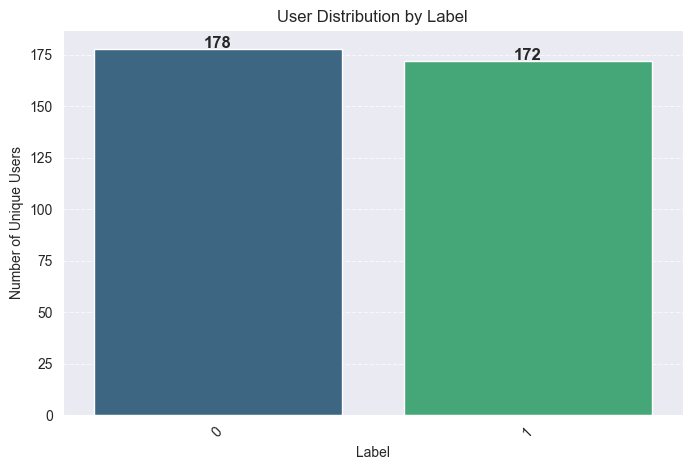

In [17]:
# Contar la cantidad de usuarios por label
user_label_counts = aggregated_df.groupby("level")["User"].nunique()

# Create the bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=user_label_counts.index, y=user_label_counts.values, palette="viridis")

# Add value labels on top of each bar
for i, v in enumerate(user_label_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", fontsize=12, fontweight="bold")

# Customize the chart
plt.xlabel("Label")
plt.ylabel("Number of Unique Users")
plt.title("User Distribution by Label")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Data augmentation

In [18]:
aggregated_df.drop(columns=['User'], inplace=True)

In [19]:
df_filtered = aggregated_df.rename(columns={'label': 'label_text'})
df_filtered

,message,label_text,level
0,el canal del amigo se llama loco por el tradin...,trading,0
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0
2,fijate cuanto e el margen en negativo y le agr...,trading,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0
4,voy cargando la escopeta pa longuear alguna mo...,trading,1
...,...,...,...
345,"buenas , saben dónde se podrán ver la órdenes ...",trading,0
346,eso e bueno o malo ? [SEP] tarde ? hasta donde...,trading,0
347,que hora e el stream de user 12434 [SEP] graci...,trading,0
348,"hola gente , le hago una consulta : tengo unos...",trading,0


In [28]:
mapping = {
    'betting': 0,
    'trading': 1,
    'lootboxes': 2,
    'onlinegaming': 3
}

df_filtered['label'] = df_filtered['label_text'].map(mapping)
df_filtered.to_excel('dataset_task1.xlsx', index=False)

C:\Users\jeiso\AppData\Local\Temp\ipykernel_6496\985504995.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


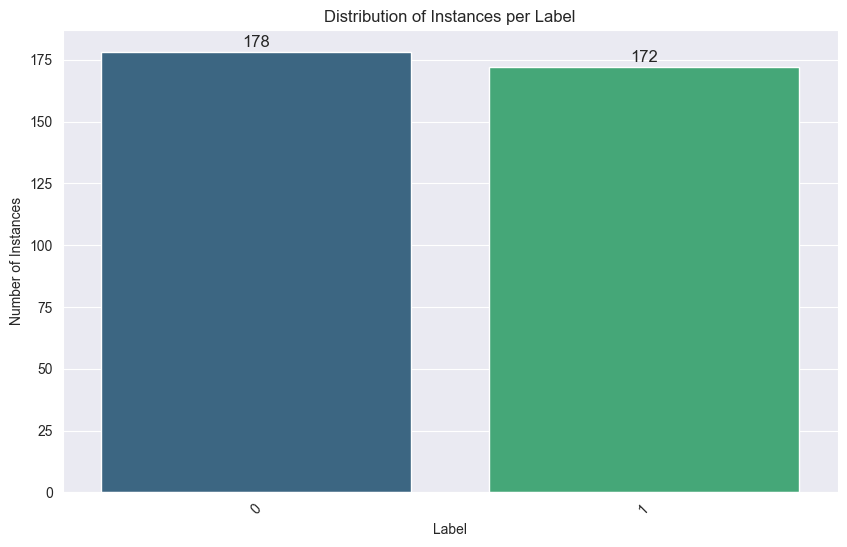

In [26]:
# Count the number of instances per label
label_counts = df_filtered['level'].value_counts()

# Plot the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Add text labels above each bar
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=12)

plt.xlabel("Label")
plt.ylabel("Number of Instances")
plt.title("Distribution of Instances per Label")
plt.xticks(rotation=45)  # Rotate labels for better visibility if there are many
plt.show()

In [27]:
df_filtered

,message,label_text,level,label
0,el canal del amigo se llama loco por el tradin...,trading,0,1
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0,1
2,fijate cuanto e el margen en negativo y le agr...,trading,1,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0,1
4,voy cargando la escopeta pa longuear alguna mo...,trading,1,1
...,...,...,...,...
345,"buenas , saben dónde se podrán ver la órdenes ...",trading,0,1
346,eso e bueno o malo ? [SEP] tarde ? hasta donde...,trading,0,1
347,que hora e el stream de user 12434 [SEP] graci...,trading,0,1
348,"hola gente , le hago una consulta : tengo unos...",trading,0,1
